# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Изучим общую информацию о данных. 

In [91]:
import seaborn as sbrn

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')

print(data.head(10))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00      3   
1             7   3350000.0       40.40  2018-12-04T00:00:00      1   
2            10   5196000.0       56.00  2015-08-20T00:00:00      2   
3             0  64900000.0      159.00  2015-07-24T00:00:00      3   
4             2  10000000.0      100.00  2018-06-19T00:00:00      2   
5            10   2890000.0       30.40  2018-09-10T00:00:00      1   
6             6   3700000.0       37.30  2017-11-02T00:00:00      1   
7             5   7915000.0       71.60  2019-04-18T00:00:00      2   
8            20   2900000.0       33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.00  2017-02-26T00:00:00      3   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0        51.00      8          NaN  ...   
1             NaN          11.0        18.60      1          NaN  ...   

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

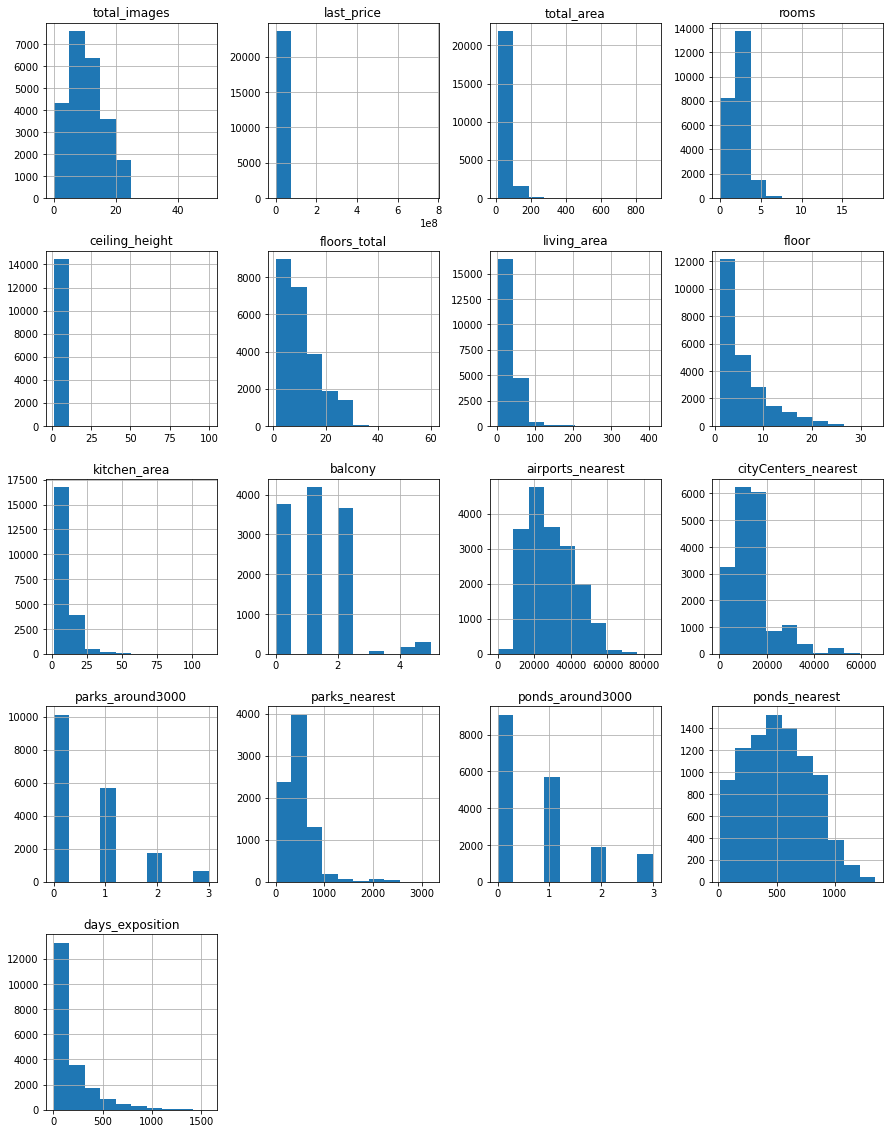

In [3]:
#Посмотрим на распределение числовых данных в наборе данных
data.hist(figsize = (15, 20))

### Предобработка данных

Проверим основную информацию по набору данных. Проверим где есть пропуски. и какая доля пропусков в каждом столбце.

In [4]:
(data
    .isna()
    .mean()
    .sort_values(ascending = False)*100)



is_apartment            88.290645
parks_nearest           65.909954
ponds_nearest           61.559559
balcony                 48.605426
ceiling_height          38.799105
airports_nearest        23.384953
cityCenters_nearest     23.287902
ponds_around3000        23.283683
parks_around3000        23.283683
days_exposition         13.422507
kitchen_area             9.612220
living_area              8.029875
floors_total             0.362885
locality_name            0.206760
total_images             0.000000
last_price               0.000000
studio                   0.000000
floor                    0.000000
rooms                    0.000000
first_day_exposition     0.000000
total_area               0.000000
open_plan                0.000000
dtype: float64

#### **Обработка пропусков, аномалий и изменение типов данных:**

Внаборе данных 23699 строк, 21 столбец.


- **`rooms`**
В стом столбце большая часть данных располагается в диапазоне 0 - 5 комнат. Квартиры с количеством комнат от 5 встречаются значительно реже. 
6 комнаятных квартир почти 300 штук, поэтому их как аномальные отбрасывать не будем. А вот квартиры с количеством комнат от 7 отбросим как аномальные.

In [5]:
#data['rooms'].hist()
#data['rooms'].hist(range = (7,15))

In [6]:
data = data.loc[data['rooms'] <= 6]

- **`is_apartment`**

Больше всего пропусков в столбце `is_apartment`. Пропуски в этом столбце оставляем как есть. Скорее - всего пользователь не указывает, что продает апартаменты. Иметь в таблице на 23699 строк всего 50 значений **True** очень странно. 

Тип данных в этом столбце - строка. Изменим тип данных на булев тип.

In [7]:
data['is_apartment'].value_counts()

False    2721
True       49
Name: is_apartment, dtype: int64

##### **`parks_nearest`**

Для заполнения пропусков в этой колонке, было бы разумно сгруппировать набор данных по столбцу `locality_name` и для всех городских поселений, исключая Санкт - Петербург и городские поселения с малым количеством количеством объявлений найти медианное растояние до парка. Этот вариант был бы рабочим, если бы парк располагался в географическом центре города. Поэтому пропуски в стом столбце не получистся заменить.
Причины может быть две: в населенном пункте нет парка, либо пропуск появился в результате технической ошибки. Вряд ли пользователи сами указывают расстояние до близжайших парков, при добавлении объявления. Скорее - всего данные в этом столбце расчитываются автоматически, в зависимости от географического расположения продаваемого объекта, и географического расположения парка в населенном пункте.
Будет разумно, если вместо столбца с расстояниями до ближайшего парка в м. использовать столбец с указанием времени пешей ходьбы до ближайшего парка со следующими категориями: 
- Парк в 5 минутах 
- Парк в 10 минутах
- Парк в 15 минутах
- Парк в 20 минутах
- Нет парков в пешей доступности (там, где пропуски и везде, где время пешком >20 минут)

*(Для расчета примем скорость ходьбы - 4 км/ч (66,67 м/мин))*

In [8]:
#Помотрим нет ли в столбце аномалных значений
data['parks_nearest'].describe() 

count    8015.000000
mean      491.208734
std       342.906455
min         1.000000
25%       288.000000
50%       455.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [9]:
#Заменим пропуски на большие числа, чтобы значения в столбцах укладывались в логику функции:
data['parks_nearest'] = data['parks_nearest'].fillna(999999)

#Судя по тому, что минимальное значение == 1, можно предположить, что отсутствие значений в этом столце означает что парков поблизости нет
def walk_to_park(distance):
    walk_speed = 66.67
    time = distance/walk_speed
    if time <= 5:
        walking_time = "Парк в 5 минутах пешком"
    elif time <= 10 and time < 5:
        walking_time = "Парк в 10 минутах пешком"
    elif time <= 15 and time < 10:
        walking_time = "Парк в 15 минутах пешком"
    elif time <= 15 and time < 20:
        walking_time = "Парк в 20 минутах пешком"
    else:
        walking_time = "Нет парков в пешей доступности"
    return walking_time

data['walk_to_park'] = data['parks_nearest'].apply(walk_to_park)

#Проверим все ли ок
data['walk_to_park'].value_counts()
#Похоже, что значение в этом столбце указывается при наличии парка на расстоянии 3000 м. 
#В случае, если парка на этом расстоянии нет, то в даных появляется пропуск. Логика не нарушена. 

Нет парков в пешей доступности    15970
Парк в 15 минутах пешком           4041
Парк в 5 минутах пешком            2508
Парк в 20 минутах пешком           1090
Name: walk_to_park, dtype: int64

##### **`ponds_nearest`**

С этим столбцом ситуация аналогична столбцу `parks_nearest` тоже заменим пропуски на категории.

In [10]:
#Помотрим нет ли в столбце аномалных значений
data['ponds_nearest'].describe()

count    9055.000000
mean      518.614467
std       277.707602
min        13.000000
25%       295.000000
50%       503.000000
75%       730.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

In [11]:
#Заменим пропуски на большие числа, чтобыпри выполнении функции сохранялась логика:
data['ponds_nearest'] = data['ponds_nearest'].fillna(999999)

#Судя по тому, что минимальное значение == 1, можно предположить, что отсутствие значений в этом столце означает что водоемлв поблизости нет
def walk_to_pound(distance):
    walk_speed = 66.67
    time = distance/walk_speed
    if time <= 5:
        walking_time = "Водоем в 5 минутах пешком"
    elif time <= 10 and time < 5:
        walking_time = "Водоем в 10 минутах пешком"
    elif time <= 15 and time < 10:
        walking_time = "Водоем в 15 минутах пешком"
    elif time <= 15 and time < 20:
        walking_time = "Водоем в 20 минутах пешком"
    else:
        walking_time = "Нет водоемов в пешей доступности"
    return walking_time

data['walk_to_pound'] = data['ponds_nearest'].apply(walk_to_pound)

#Проверим все ли ок
data['walk_to_pound'].value_counts()

Нет водоемов в пешей доступности    14903
Водоем в 15 минутах пешком           3651
Водоем в 5 минутах пешком            2616
Водоем в 20 минутах пешком           2439
Name: walk_to_pound, dtype: int64

<div class="alert alert-success">

**✔️ Комментарий ревьюера ✔️**
   
   Интересный способ👍

</div>


##### **`balcony`**

Как было сказано в преамбуле задания - пропущенные значения скорее - всего означают то, что балкона в квартире просто нет. Поэтому пропущенные значения стоит заменить на 0. 

Так как количество балконов это целое число - изменим тип данных на "int".

In [12]:
#Заменим пропуски нулями и посмотрим на распределение количества балконов 
data['balcony'] = data['balcony'].fillna(0)
#data['balcony'].hist()
# в целом все ок, основную часть данных составляют 0-2'балконные квартиры. А вот 3-5 балконов это уже итересно. 
#Посмотрим на количество балконов в разрезе колиества комнат

#Изменим тип данных на 'int'
data['balcony'] = data['balcony'].astype(int)


data.pivot_table(index = 'rooms', columns = 'balcony', values = 'floor', aggfunc = 'count')
#Интересно выглядят 1к кв. и 2к кв., в которых количество балконов в 2 раза превышае колиество комнат. 
#Думаю будет разумно удалить из данных строки в которых количество балконов выглядит странно:
#rooms == 1, balcony > 2; 
#rooms == 2, balcony > 2; 
#В остальных случаях могут иметь место большие квартиры с нестандартными планировками. Так что остальное оставляем

balcony,0,1,2,3,4,5
rooms,,,,,,
0,83.0,29.0,85.0,NaN,NaN,NaN
1,5048.0,1472.0,1484.0,2.0,16.0,25.0
2,5079.0,1547.0,1149.0,21.0,61.0,83.0
3,3779.0,916.0,829.0,41.0,83.0,166.0
4,880.0,156.0,91.0,12.0,18.0,23.0
5,252.0,44.0,16.0,4.0,5.0,5.0
6,84.0,17.0,4.0,NaN,NaN,NaN


In [13]:
def remove_balcony_anomalies(df):
    rooms = df['rooms']
    balcony = df['balcony']
    
    if (rooms == 2 or rooms == 1) and balcony > 2:
        flag = 'remove'
    else:
        flag = 'ok'
    return flag

data['flag_balcony'] = data.apply(remove_balcony_anomalies, axis = 1)
data['flag_balcony'].value_counts()

data = data.loc[data['flag_balcony'] == 'ok']
len(data)

23401

##### **`ceiling_height`**

Пропуски в этом столбце скорее - всего обусловлены тем, что пользователи не указывают высоту потолков в квартире. Заменить их стоит на медианное значение высоты полоков по всему набору данных в зависимости от количества комнат в квартире.

In [14]:
#Посмотрим основную информацию о солбце данных
data['ceiling_height'].describe()
#В этом столбце наблюдается явные выбросы посмотрим на гистограмме

count    14283.000000
mean         2.758654
std          0.921569
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         32.000000
Name: ceiling_height, dtype: float64

<AxesSubplot:>

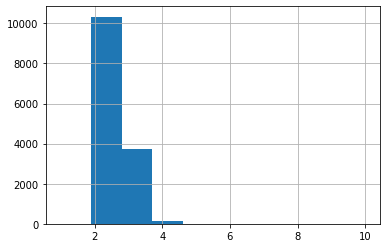

In [15]:
#Большая часть данных расположена в диапазоне 2 - 4 м, но встречаются отдельные квартиры с восотой потолков 5-7 м. Логиеск они соответствуют цене и ощей площади. Их оставляем.
#Значения больше 7 м будем считать аномальными.
#data['ceiling_height'].hist()

data['ceiling_height'].hist(range = (1,10))


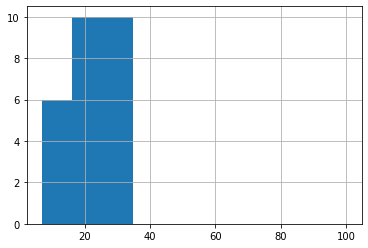

In [16]:
#посмотрим на срез данных где высота потолков больше 7м
data['ceiling_height'].hist(range = (7, 100))
#Аномальных значений не так много. Всего одно объявление с высотой 100 м. Его мы отбросим. 
data = data.query('ceiling_height != 100')

Строки с высотой потолков от 7м до 19м можно отбросить, но я заменю на медианные по похожим по количеству комнат квартирам, поскольку такие значения логически не сопоставляются с площадью квартиры и ценой. 
Строки со значениями высоты от 20 заменим на значения в 10 раз меньше, поскольку пользователь мог ошибиться.


In [17]:
data.loc[data['ceiling_height'] >= 7, ['ceiling_height', 'total_area', 'last_price']].value_counts()

ceiling_height  total_area  last_price
8.0             30.0        1400000.0     1
                54.0        5350000.0     1
27.5            42.0        4900000.0     1
27.0            98.0        4000000.0     1
                58.0        3800000.0     1
                56.0        3900000.0     1
                54.0        2500000.0     1
                45.0        8000000.0     1
                44.0        2450000.0     1
                25.0        3000000.0     1
26.0            50.0        4400000.0     1
25.0            55.2        3600000.0     1
                45.0        4300000.0     1
                44.4        3300000.0     1
                43.0        3750000.0     1
                42.0        3950000.0     1
                37.0        1950000.0     1
                35.0        1700000.0     1
24.0            30.5        3850000.0     1
22.6            60.0        5950000.0     1
20.0            92.9        6700000.0     1
14.0            56.4        5600000.0

In [18]:
#Сохраним в отдельный набор данных медианную высоту потолков по квартирам с определеным количеством комнат
median_ceiling_height = data.pivot_table(index = 'rooms', values = 'ceiling_height', aggfunc = 'median').reset_index()
median_ceiling_height

,rooms,ceiling_height
0,0,2.75
1,1,2.64
2,2,2.60
3,3,2.65
4,4,2.80
5,5,3.10
6,6,3.20


In [19]:
#Напишем функцию для замены аномальных значений. Те значения которые больше 20м, будут уменьшены в 10 раз.
#Значения от 7 до 19 м заменим на нули, чтобы на следующем шаге сделать замену.
def correct_ceiling_height(row):
    if row >= 20:
        row = row/10
    elif row >= 7 and row <= 19:
        row = 0
    return row

data['ceiling_height'] = data['ceiling_height'].apply(correct_ceiling_height)

Для заполнения пропусков сделаем следующее:

**1** Все пропуски заменим на 0.

**2**. Сгруппируем данные о высоте потолков по столбцу с количеством комнат и вычислим медианную высоту потолка в каждой категории (уже сделано).

**3**. Заменим 0 на медианную высоту потолка в зависимости от количества комнат.


In [20]:
data['ceiling_height'] = data['ceiling_height'].fillna(0)
#Убил целый день на эту функцию. Получилась капитальная (но работающая) грязь. 
#Подскажи плиз как можно сделать замену изящнее :((

def get_ceiling_height(row):
    rooms_number = row['rooms']
    ceiling_height = row['ceiling_height']
    
    if ceiling_height == 0:
        for index in range(0, len(median_ceiling_height)):
            if rooms_number == median_ceiling_height.loc[index, ['rooms']].item():
                ceiling_height = median_ceiling_height.loc[index, ['ceiling_height']].item()
    return ceiling_height

data['ceiling_height'] = data.apply(get_ceiling_height, axis = 1)
#Проверим все ли ок:
#data['ceiling_height'].hist()
#Квартиры с высотой потолков до 2 м отбросим как аномальные
data = data.loc[data['ceiling_height'] >=2]
#¯\_(ツ)_/¯

##### **`airports_nearest`**

Ситуация аналогична стобцам `ponds_nearest` и `parks_nearest`. Вместо столбца с расстояними, добавим столбец со следующими категориями:
- Аэропорт в 10 минутах на общественном транспорте
- Аэропорт в 20 минутах на общественном транспорте
- Аэропорт в 30 минутах на общественном транспорте

*Примем среднюю скорость объественного транспорта - 60 км/ч (1000 м/мин)

In [21]:
#Заменим пропуски на большие числа, чтобы значения в столбцах укладывались в логику функции:
data['airports_nearest'] = data['airports_nearest'].fillna(999999)

#Судя по тому, что минимальное значение == 1, можно предположить, что отсутствие значений в этом столце означает что парков поблизости нет
def ride_to_airport(distance):
    speed = 1000
    time = distance/speed
    if time <= 10:
        ride_time = "10 минут на общественном транспорте"
    elif time <= 20 and time < 10:
        ride_time = "20 минут на общественном транспорт"
    elif time <= 30 and time < 20:
        ride_time = "30 минут на общественном транспорт"
    else:
        ride_time = "Нет аэропорта поблизости"
    return ride_time

data['ride_to_airport'] = data['airports_nearest'].apply(ride_to_airport)

#Проверим все ли ок
data['ride_to_airport'].value_counts()

Нет аэропорта поблизости               18088
30 минут на общественном транспорт      5003
10 минут на общественном транспорте      307
Name: ride_to_airport, dtype: int64

##### **`cityCenters_nearest`**

Пропуски в этом столбце скорее - всего обусловлены технической ошибкой, поскольку пользователь не указывает вручную расстояние до центра города при добавлении объявления. Думаю, что расстояние до центра города определяется автоматически на основании географического расположения продаваемого объекта и географического центра города. Заменить пропуски в этом столбце вряд ли получится, посколько нет ни координат, ни адреса, ни каких-либо косвенных признаков, позволивших бы определить расположение объекта относительно центра города. 
Так что оставляем как есть.

In [22]:
#Проверим для каких поселений расчитано расстояние до центра города
data.loc[data['cityCenters_nearest'] > 0, ['locality_name']].value_counts()

#О! Расстояние до центра рассчитано для Санкт - Петербурга. Разделим данные на 3 категории: 
#Будем считать, что все, что насстоянии до 5000 м - СПб - центр
#Все остальное - СПб
#Везде, где пропуски - ЛО

locality_name          
Санкт-Петербург            15433
посёлок Шушары               432
Пушкин                       365
Колпино                      333
посёлок Парголово            326
Петергоф                     200
Сестрорецк                   181
Красное Село                 175
Ломоносов                    132
Кронштадт                     94
посёлок Металлострой          66
посёлок Стрельна              44
Павловск                      38
Зеленогорск                   24
посёлок Понтонный             20
посёлок Сапёрный               6
посёлок Молодёжное             5
посёлок Репино                 4
посёлок Песочный               3
посёлок Лисий Нос              2
посёлок Усть-Ижора             2
посёлок Александровская        2
поселок Мурино                 2
посёлок Левашово               1
посёлок Петро-Славянка         1
посёлок Белоостров             1
поселок Лисий Нос              1
посёлок Щеглово                1
dtype: int64

In [23]:
def get_location_categoty(row):
    max_distance = data['cityCenters_nearest'].max()
    location =data['locality_name']
    if row <= 5000:
        return 'СПб - Центр'
    elif row > 5000 and row <= max_distance:
        return 'СПб'
    else:
        return 'ЛО'
    
data['location_category'] = data['cityCenters_nearest'].apply(get_location_categoty)

##### **`ponds_around3000`** и **`parks_around3000`**

Пропуски в этих столбцах обусловлены технической ошибкой, поскольку количество пропусков в них одинаковое и не равно количеству пропусках ни в одном другом столбце набора данных. 
Можно было бы предположить, что пропуски обусловлены отсутствием парков поблизости, но в столбце почти 6тыс. нулей. Так что оставляем как есть.

Тип данных изменим на 'int' не представляется возможным, поскольку тип данных у пропусков - 'float'. Заполнить пропуски нет возможности, отбросить тоже нельзя. Так что оставляем как есть.

In [24]:
data['ponds_around3000'].value_counts()

0.0    8966
1.0    5645
2.0    1855
3.0    1470
Name: ponds_around3000, dtype: int64

In [25]:
data['parks_around3000'].value_counts()

0.0    10003
1.0     5587
2.0     1715
3.0      631
Name: parks_around3000, dtype: int64

##### `days_exposition`   

Т.к. минимальное значение в столбце == 1, то пропуски в этом столбце могут быть обусловлены тем, что объект на момент выгрузки не был продан. Пропуски оставляем как есть.

Чтобы изменить тип данных на целое цисло, нужно заменить пропуски на нули. Логика от этого не нарушится. 0 дней с момента продажи = квартира еще не продана.

In [26]:
data['days_exposition'].describe()

count    20283.000000
mean       180.695706
std        219.458137
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1572.000000
Name: days_exposition, dtype: float64

In [27]:
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')

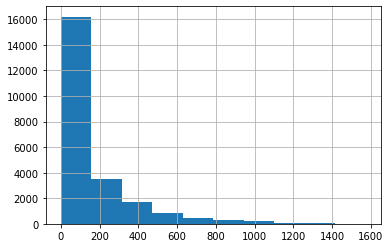

In [28]:
#Квартиры, которые продавались больше 800 дней будем считать аномальными.  Отбросим их.
data['days_exposition'].hist()
data = data.loc[data['days_exposition'] < 800]

##### `kitchen_area`    
Пропуски в этом столце обусловлены тем, что пользователи при размещении объявления не указывают проладь кухни. Для того, чтобы заполнить пропуски, сгруппируем квартиры по кличеству комнат и в каждой группе найдем медиану.

In [29]:
data['kitchen_area'].describe()

count    20588.000000
mean        10.455615
std          5.697454
min          1.300000
25%          7.000000
50%          9.000000
75%         11.950000
max        107.000000
Name: kitchen_area, dtype: float64

<AxesSubplot:>

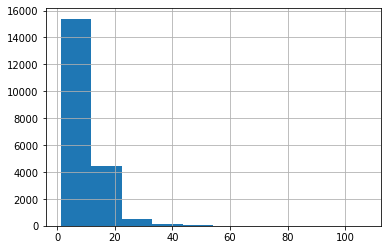

In [30]:
data['kitchen_area'].hist()

На гистограмме видно, что большая часть значений расположина в диапазоне 1-20 м2. Проверим каким общим площадям и количеству комнат соответствуют квартиры с площадью кухни 1-4 м2:

In [31]:
data.loc[data['kitchen_area'] <= 4, ['locality_name', 'kitchen_area', 'total_area', 'rooms']]

,locality_name,kitchen_area,total_area,rooms
906,Санкт-Петербург,2.00,27.00,1
1853,посёлок Песочный,4.00,38.30,2
2165,посёлок Мурино,3.00,25.00,1
3078,Санкт-Петербург,3.20,43.00,2
3195,Санкт-Петербург,3.80,25.60,1
4777,поселок Мурино,4.00,28.20,1
5193,Санкт-Петербург,4.00,27.00,1
6084,Тихвин,3.00,18.00,1
6262,Санкт-Петербург,2.00,24.00,2
6544,Санкт-Петербург,4.00,20.30,1


Такие площади кухонь выглядят весьма странно. Эти данные, конечно, аномальные, однако чего только не бывает в старом фонде, так что оставляем как есть. 
Посмотрим что с площадями от 50 м2:

In [32]:
data.loc[data['kitchen_area'] >= 50, ['locality_name', 'kitchen_area', 'total_area', 'rooms', 'last_price', 'open_plan']]
#50 метровая кухня в Муринской однушке это интересно.
#В остальном все логически объяснимо - населенные пункты с множеством квартир с нестандарстной планировкой, высокая цена и большая площадь
#Оставляем как есть. Не вижу причины удалять или заменять аномальные значения.

,locality_name,kitchen_area,total_area,rooms,last_price,open_plan
51,Санкт-Петербург,50.0,161.0,3,45000000.0,False
492,Санкт-Петербург,77.0,216.0,4,95000000.0,False
511,посёлок Мурино,50.0,69.0,1,5950000.0,False
656,Санкт-Петербург,50.0,131.0,3,18500000.0,False
793,Санкт-Петербург,50.0,310.0,4,135000000.0,False
1026,Санкт-Петербург,63.0,310.0,5,155000000.0,False
1085,Санкт-Петербург,66.0,323.0,5,75000000.0,False
2356,Санкт-Петербург,50.0,128.0,3,50000000.0,False
2489,Санкт-Петербург,100.7,255.0,3,12500000.0,False
3561,Санкт-Петербург,60.0,115.0,3,12300000.0,False


In [33]:
#Сохраним в отдельный набор данных медианную площадь кухонь по квартирам с определеным количеством комнат
median_kitchen_area = data.pivot_table(index = 'rooms', values = 'kitchen_area', aggfunc = 'median').reset_index()
median_kitchen_area

,rooms,kitchen_area
0,1,9.00
1,2,8.60
2,3,9.50
3,4,11.00
4,5,15.00
5,6,19.75


In [34]:
#Сделаем ту же грязь что и с высотой потолков)))
data['kitchen_area'] = data['kitchen_area'].fillna(0)

def get_kitchen_area(row):
    rooms_number = row['rooms']
    kitchen_area = row['kitchen_area']
    
    if kitchen_area == 0:
        for index in range(0, len(median_kitchen_area)):
            if rooms_number == median_kitchen_area.loc[index, ['rooms']].item():
                kitchen_area = median_kitchen_area.loc[index, ['kitchen_area']].item()
    return kitchen_area

data['kitchen_area'] = data.apply(get_kitchen_area, axis = 1)
#Проверим все ли ок:
data['kitchen_area'].isna().sum()
#¯\_(ツ)_/¯ ¯\_(ツ)_/¯

0

<AxesSubplot:title={'center':'3 rooms'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'1 rooms'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'2 rooms'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'4 rooms'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'5 rooms'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'6 rooms'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'0 rooms'}, ylabel='Frequency'>

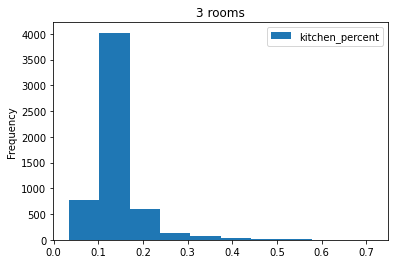

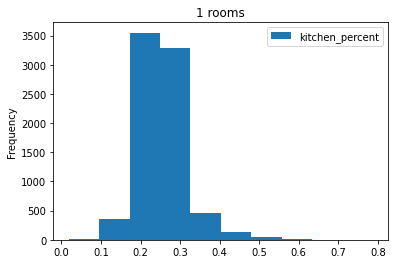

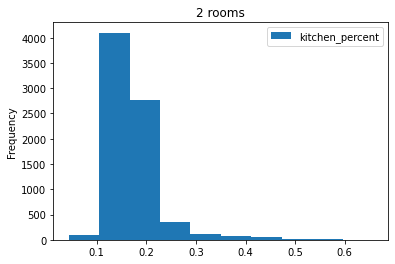

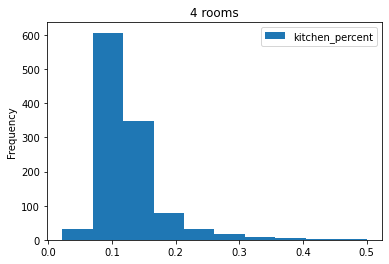

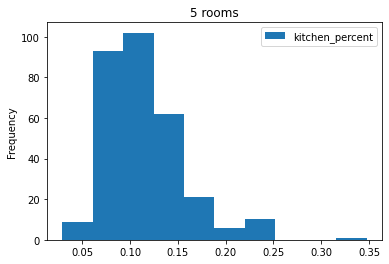

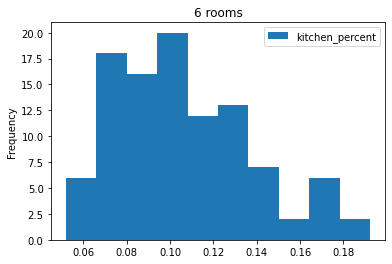

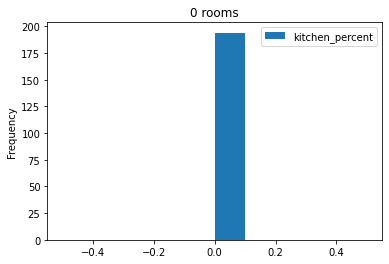

In [35]:
#Посмотрим на распределение отношения площади кухни к общей площади квартиры
data['kitchen_percent'] = data['kitchen_area']/data['total_area']
#Посмотрим как распределяется соотношение в зависимости от количества окмнат в квартире

for rooms in data['rooms'].unique():
    title = str(rooms) + ' rooms'
    display(data.loc[data['rooms'] == rooms, ['kitchen_percent']].plot(y = 'kitchen_percent', kind = 'hist', bins = 10, title = title))
    #Для однокомнатных, отбросим квартиры, где соотношение кухни и общей площади <10%
    #То же сделаем для двухкомнатных квартир
    #Думаю остальные трогать не стоит, тк квартиры с большим количеством комнат вряд ли имеют стандартную планировку.

    
#data['kitchen_percent'].hist(range=(0,0.1))

In [36]:
def remove_kitchen_anomalies(df):
    rooms = df['rooms']
    kitchen_percent = df['kitchen_percent']
    
    if (rooms == 2 or rooms == 1) and kitchen_percent <= 0.1:
        flag = 'remove'
    else:
        flag = 'ok'
        return flag

data['flag_kitchen'] = data.apply(remove_kitchen_anomalies, axis = 1)
data['flag_kitchen'].value_counts()

data = data.loc[data['flag_kitchen'] == 'ok']
#Откинем, пожалуй еще и те квартиры, где соотношение кухни и площади меньше 0,08
data = data.loc[data['kitchen_percent'] > 0.08]
len(data)

22307

##### `living_area`
Тут пропуски обусловлены тем, что польователи не указывают жилую площадь, когда публикуют объявление. Можно было бы вычислить жилую площадь как разность общей площади и всей остальное (санузел, корридор, кухня), но таких данных в наборе нет. Так что единственный 


In [37]:
data['living_area'].describe()

count    20549.000000
mean        33.343643
std         18.651451
min          2.000000
25%         18.500000
50%         30.000000
75%         42.000000
max        300.000000
Name: living_area, dtype: float64

<AxesSubplot:>

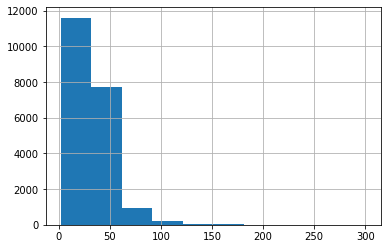

In [38]:
data['living_area'].hist()
#Основная часть данных раполагается в диапазоне 2 - 150 м2. 
#Проверим насколько сопоставляются с общей площадью квартиры, с жилой площадью до 20 м2 и от 150 м2

In [39]:
#data.loc[(data['living_area'] < 10) | (data['living_area'] > 200), ['total_area', 'living_area', 'last_price']]
#С большими площадями все ок. Подробнее проверим малые жилые площади
data.loc[data['living_area'] < 10, ['total_area', 'living_area', 'last_price', 'rooms']]
#Честно говоря, весь срез выглядит странно. Могу еще поверить в малую жилую площадь в квартирах до 20 м2. Остальное выглядит не очень праавдоподобно.

,total_area,living_area,last_price,rooms
114,21.40,8.3,4000000.0,1
680,43.00,9.0,7200000.0,1
1326,52.00,9.0,8100000.0,2
2309,62.40,8.4,4200000.0,2
3242,41.00,3.0,4440000.0,1
4100,34.80,9.0,5300000.0,1
4542,18.00,9.0,3300000.0,1
7312,27.00,9.0,3400000.0,2
8325,52.00,9.0,4800000.0,2
13915,52.00,2.0,6350000.0,2


Думаю что вряд ли жилая площадь квартиры может быть больше чем в 2 раза ниже, чем общая площадь. Поэтому строки, где это соотношение не соблюдается, будем считать аномальными и удалим из набора данных. Можно было бы заменить их на медианные значения в зависимости от количества комнат, но пришлось бы делить квартиры на категории в зависимости от площади, но я и так сижу на этом этапе уже неделю. Так что просто откидываем, а пропуски заменяем на медианы.

In [40]:
median_living_area = data.pivot_table(index = 'rooms', values = 'living_area', aggfunc = 'median').reset_index()
median_living_area

,rooms,living_area
0,1,17.60
1,2,30.40
2,3,44.90
3,4,62.50
4,5,89.55
5,6,123.60


In [41]:
#Снова делаем грязь
data['living_area'] = data['living_area'].fillna(0)

def get_living_area(row):
    rooms_number = row['rooms']
    living_area = row['living_area']
    
    if living_area == 0:
        for index in range(0, len(median_living_area)):
            if rooms_number == median_living_area.loc[index, ['rooms']].item():
                living_area = median_living_area.loc[index, ['living_area']].item()
    return living_area

data['living_area'] = data.apply(get_living_area, axis = 1)
#Проверим все ли ок:
data['living_area'].isna().sum()
#¯\_(ツ)_/¯ ¯\_(ツ)_/¯ ¯\_(ツ)_/¯

0

<AxesSubplot:>

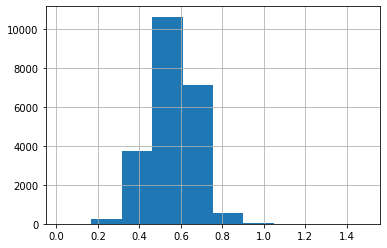

In [42]:
#Проверим соотношение жилой и общей площади в квартирах
data['livind_area_percent'] = data['living_area']/ data['total_area']
data['livind_area_percent'].hist()
#Опа, нормальное распределение. Попробую воспользоваться понятием квартилей и межквартильным размахом: 
#Попробуем удалить все, что выходит за пределы 1,5*межквартильный размаха

In [43]:
def get_clean_data(col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    data_clean = data.loc[(data[col]  < q3 + 1.5*iqr) & (data[col]  > q1 - 1.5*iqr)]
    return data_clean

len(data) - len(get_clean_data('livind_area_percent'))
#Думаю 244 строк это не большяа потеря. Оставим так. Если бы не этот метод, то я бы просто откинул все, где livind_area_percent < 0.2 и livind_area_percent >= 1 

220

In [44]:
data = get_clean_data('livind_area_percent')

##### `floors_total` и `locality_name`.

Тут пропуски ничем не заменить. Был бы столбец с адресом, то можно было бы восстановить оба столбца. Полагаю, что оба этих стобца заполняются автоматически, так что пропуски тут это скорее - всего техническая ошибка. Количество пропусков и там и там небольшое, так что отбросим пропущенные значения.

In [45]:
display(data['floors_total'].isna().sum())
display(data['locality_name'].isna().sum())

78

46

In [46]:
data = data.dropna(subset=['floors_total', 'locality_name']).reset_index(drop = True)

##### `first_day_exposition`
Тут тип данных почему - то строка. Изменим на дату.

In [47]:
data['first_day_exposition']= pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['first_day_exposition']

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2018-06-19
4       2018-09-10
           ...    
21959   2017-03-21
21960   2018-01-15
21961   2018-02-11
21962   2017-03-28
21963   2017-07-21
Name: first_day_exposition, Length: 21964, dtype: datetime64[ns]

##### `last_price`

In [48]:
data['last_price'].describe()

count    2.196400e+04
mean     6.076474e+06
std      7.454031e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.596500e+06
max      3.300000e+08
Name: last_price, dtype: float64

<AxesSubplot:>

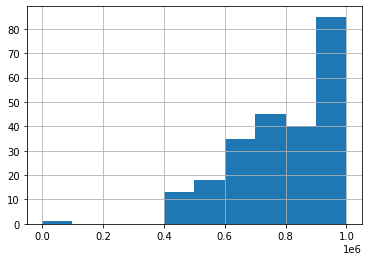

In [49]:
data['last_price'].hist(range = (0, 1000000))
#Квартир с ценой до 1млн.руб. совсем мало. Посмотрим на этот срез.  Может они находятся в глубокой ленинградской области

In [50]:
#Ну да, в целом так и получается
data.loc[data['last_price'] <= 1000000,['last_price', 'total_area', 'locality_name']].head(50)
#Работать с такими большими числами не удобно, так что создадим новый столбец и запишем туда цену в тыс.руб.
data['last_price_thousands'] = (data['last_price']/1000).round(decimals = 2)
data['last_price_thousands']

0        13000.0
1         3350.0
2         5196.0
3        10000.0
4         2890.0
          ...   
21959     9700.0
21960     3100.0
21961     2500.0
21962    11475.0
21963     1350.0
Name: last_price_thousands, Length: 21964, dtype: float64

In [88]:
#Посмотрим что по итогу получилось
data.isna().sum()

total_images                  0
last_price                    0
total_area                    0
first_day_exposition          0
rooms                         0
ceiling_height                0
floors_total                  0
living_area                   0
floor                         0
is_apartment              19409
studio                        0
open_plan                     0
kitchen_area                  0
balcony                       0
locality_name                 0
airports_nearest              0
cityCenters_nearest        5173
parks_around3000           5172
parks_nearest                 0
ponds_around3000           5172
ponds_nearest                 0
days_exposition               0
walk_to_park                  0
walk_to_pound                 0
flag_balcony                  0
ride_to_airport               0
location_category             0
kitchen_percent               0
flag_kitchen                  0
livind_area_percent           0
last_price_thousands          0
price_pe

#### Убираем неявные дубликаты из столбца с названием населенного пункта.

In [52]:
#Напишем функцию, которая будет разбивать название каждого населенного пункта и оставлять только слова, содержащие заглавные буквы
def extract_city_name(row):
    city_name = [row for row in row.split(" ") if row.istitle()]
    return " ".join(city_name)

data['locality_name'] = data['locality_name'].apply(extract_city_name)


### Добавим в таблицу новые столбцы

In [53]:
#Цена одного м2:
data['price_per_sqm'] = data['last_price']/data['total_area']
#День недели
data['week_day'] = data['first_day_exposition'].dt.weekday
#Месяц
data['month'] = data['first_day_exposition'].dt.month 
#Год
data['year'] = data['first_day_exposition'].dt.year 

In [54]:
#Какой этаж?
def get_floor(data):
    floor = data['floor']
    floors_total = data['floors_total']
    
    if floor == 1:
        return 'Первый'
    elif floor == floors_total:
        return 'Последний'
    else:
        return 'Другой'
    
data['wich_floor'] = data.apply(get_floor, axis = 1)
data['wich_floor'].value_counts()

Другой       16176
Последний     3073
Первый        2715
Name: wich_floor, dtype: int64

In [55]:
#Расстояние до центра в км
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']/1000).round(decimals = 0)
data['cityCenters_nearest_km']

0        16.0
1        19.0
2        14.0
3         8.0
4         NaN
         ... 
21959     4.0
21960     NaN
21961     NaN
21962    10.0
21963     NaN
Name: cityCenters_nearest_km, Length: 21964, dtype: float64

<div class="alert alert-success">

**✔️ Комментарий ревьюера ✔️**
   
   В данном блоке все верно👍

</div>


### Проведите исследовательский анализ данных

####  `total_area`

<AxesSubplot:>

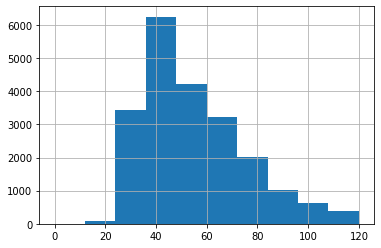

In [56]:
#data['total_area'].hist()
data['total_area'].hist(range=(0,120))
#data['total_area'].hist(range=(120,300))
#data['total_area'].hist(range=(300,900))

In [57]:
data['total_area'].describe()

count    21964.000000
mean        58.197684
std         28.533981
min         12.000000
25%         40.000000
50%         51.200000
75%         68.000000
max        491.000000
Name: total_area, dtype: float64

На гистограмме видно, что подавляющая часть квартир в диапазоне 12 - 200 м2. 

- Средняя площадь - 60 м2.
- Медианная площадь - 52 м2.
- Больше всего квартир с площадью  12 - 120 м2.
- Меньше квартир с  лощадью в диапазоне 120 - 300 м2
- Реже всего встречаются квартиры с площадью в диапазоне 300 - 900 м2.

####  `living_area`

<AxesSubplot:>

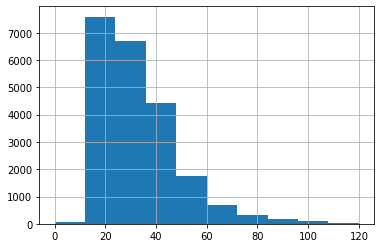

In [58]:
#data['living_area'].hist()
data['living_area'].hist(range=(0,120))
#data['living_area'].hist(range=(120,300))
#data['living_area'].hist(range=(300,800))

In [59]:
data['living_area'].describe()

count    21964.000000
mean        33.186850
std         18.320867
min          8.300000
25%         18.300000
50%         30.000000
75%         42.000000
max        300.000000
Name: living_area, dtype: float64

Гистограмма распределения жилой площади практически повторяет гистограмму значения общей площади, но значения по оси абсцисс в смещено в 2 раза, что говорит, что в среднем жилая площадь составляет половину общей площади квартиры.

- Средняя жилая площадь - 34.3 м2.
- Медианная жилая площадь - 30 м2.
- Больше всего квартир с жилой площадью  8 - 80 м2.
- Меньше квартир с жилой площадью в диапазоне 120 - 300 м2
- Реже всего встречаются квартиры с жилой площадью в диапазоне 300 - 400 м2.

####  `kitchen_area`

<AxesSubplot:>

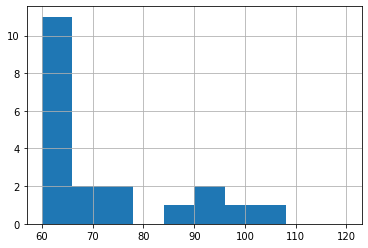

In [60]:
#data['kitchen_area'].hist()
#data['kitchen_area'].hist(range=(0,30))
#data['kitchen_area'].hist(range=(30, 60))
data['kitchen_area'].hist(range=(60,120))

In [61]:
data['kitchen_area'].describe()

count    21964.000000
mean        10.302481
std          5.374951
min          2.000000
25%          7.200000
50%          9.000000
75%         11.300000
max        107.000000
Name: kitchen_area, dtype: float64

Гистограмма распределения площади кухни похожа на предыдущие. Значения по оси абсцисс в смещено в 10 раз, можно предположить, что в среднем, кухня составляет 1/10 площад всей квартиры.

- Медианная площадь кухни - 9 м2.
- Средняя площадь кухни - 10.4 м2.
- Больше всего квартир с кухней от 3 до 20 м2.
- Меньше квартир в с кухней в диапазоне 30 - 60 м2.
- Реже всего продаются квартиры с площадью кухни от 60 м2.


#### `last_price`

<AxesSubplot:>

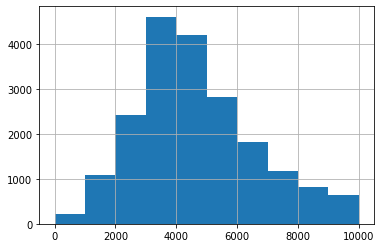

In [62]:
data['last_price_thousands'].hist(range = (0, 10000))

In [63]:
data['last_price_thousands'].describe()

count     21964.000000
mean       6076.474477
std        7454.031186
min          12.190000
25%        3400.000000
50%        4600.000000
75%        6596.500000
max      330000.000000
Name: last_price_thousands, dtype: float64

- БОльшая часть цен располагается в диапазоне 3 - 8 млн.руб.
- Квартиры с ценой до 3 и от 8 млн.руб встречаются реже.
- Медианная цена квартиры - 4.6 млн.руб
- Средняя цена - 6.2 млн.руб

#### `rooms`

In [64]:
#data['rooms'].hist()
#data['rooms'].hist(range = (0,4))
#data['rooms'].hist(range = (5,15))


In [65]:
data['rooms'].describe()

count    21964.000000
mean         2.038290
std          0.968492
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

- Медианное количество комнат - 2.
- Среднее количество комнат - 2.
- Больше всего продаеся квартир с 1-3 комнатами
- Значительно реже - с количеством комнат 4 - 15

#### `ceiling_height`

<AxesSubplot:>

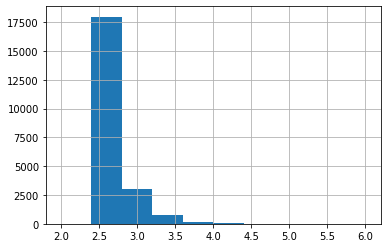

In [66]:
data['ceiling_height'].hist()
#data['ceiling_height'].hist(range=(0,4))

In [67]:
data['ceiling_height'].describe()

count    21964.000000
mean         2.685976
std          0.214724
min          2.000000
25%          2.600000
50%          2.640000
75%          2.700000
max          6.000000
Name: ceiling_height, dtype: float64

Большая часть данных распределена в диапазоне 2 - 3,5 м.

- Медианная высота потолков - 2,64 м.
- Средняя высота потолков - 2,7 м.
- Больше всего квартир с высотой потолков 2 - 3,5 м.
- Значительно меньше квартир с высоток потолков от 3,5 м.

#### `floor`

<AxesSubplot:>

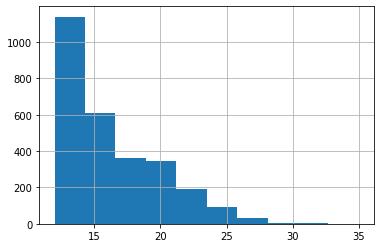

In [68]:
#data['floor'].hist()
#data['floor'].hist(range = (0, 12))
data['floor'].hist(range = (12, 35))

In [69]:
data['floor'].describe()

count    21964.000000
mean         5.860453
std          4.846415
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

Больше всего квартир находятся на 1 - 12 этажах, что логично: среди построенных домов больше всего 5-9 этажный. Среди построенных недавно - много домов, где больше 9 этажей.

- В среднем квартиры располагаются на 6 этаже
- Медианный этаж - 4
- Чаще всего встречаются квартиры на 1 - 12 этажах
- на 12+ этажах квартир меньше всего

#### `wich_floor`

In [70]:
data['wich_floor'].value_counts()

Другой       16176
Последний     3073
Первый        2715
Name: wich_floor, dtype: int64

- Больше всего квартир продается на не первом и не последних этажах.
- Количество квартир на первом и на последих этажах примерно одинаковое.

#### `floors_total`

<AxesSubplot:>

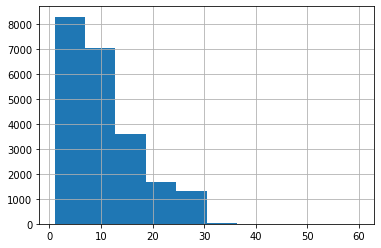

In [71]:
data['floors_total'].hist()

In [72]:
data['floors_total'].describe()

count    21964.000000
mean        10.669049
std          6.571956
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

- Медианная высота дома, в котором продается квартира - 9 этажей.
- Средняя высота дома - 10 этажей
- Большая часть объявлений рахмешено в домах, где 1 - 20 этажей.
- Значительно меньше объявлений в домах от 20 этажей.


#### `cityCenters_nearest`

<AxesSubplot:>

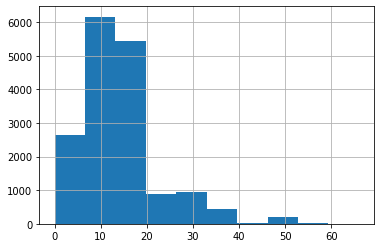

In [73]:
data['cityCenters_nearest_km'].hist()

In [74]:
data['cityCenters_nearest'].describe()

count    16791.000000
mean     14393.745816
std       8580.316356
min        181.000000
25%       9632.000000
50%      13223.000000
75%      16362.500000
max      65952.000000
Name: cityCenters_nearest, dtype: float64

In [75]:
data['location_category'].value_counts()

СПб            15043
ЛО              5173
СПб - Центр     1748
Name: location_category, dtype: int64

- Медианное расстояние до центра города - 13.2 км
- Среднее расстояние до центра - 14,3 км.
- Большая часть квартир, продаваемых в Санкт - Петербурге, находится на расстоянии до 20 км от центра
- Значительно меньше квартир на расстоянии от 20 км до центра.
- Больше всего объявлений из Санкт - Петребурга и ближайших пригородов.

#### `airports_nearest`

<AxesSubplot:>

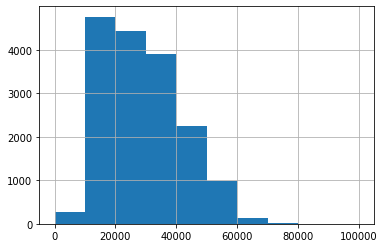

In [76]:
data['airports_nearest'].hist(range=(0, 100000))

In [77]:
data['ride_to_airport'].value_counts()

Нет аэропорта поблизости               16924
30 минут на общественном транспорт      4755
10 минут на общественном транспорте      285
Name: ride_to_airport, dtype: int64

In [78]:
data['airports_nearest'].describe()

count     21964.000000
mean     258406.721681
std      412717.770789
min           0.000000
25%       21036.000000
50%       33792.000000
75%       55456.500000
max      999999.000000
Name: airports_nearest, dtype: float64

- Большая часть квартир находится на расстоянии от 10 до 60 км до аэропорта.
- Медианное расстояние до аэропорта - 33.7 км
- Среднее расстояние до аэропорта - 25.7 км.

#### `day`, `month`, `year`

<AxesSubplot:>

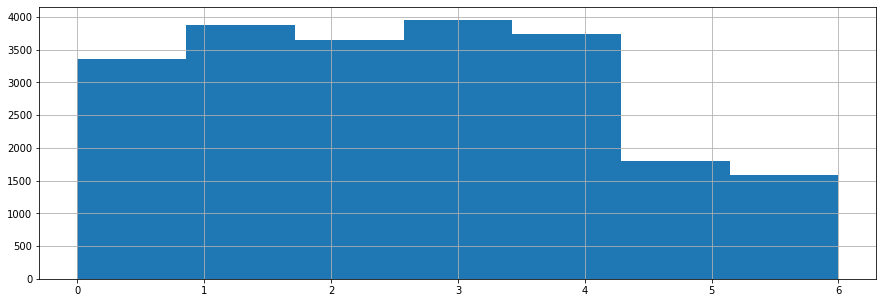

In [79]:
data['week_day'].hist(bins = 7, figsize = (15,5))

Из гистограммы видно, что в основном пользователи выкладывают объявления в будние дни. Больше всего - в четверг. Меньше всего - в воскресенье.

<AxesSubplot:>

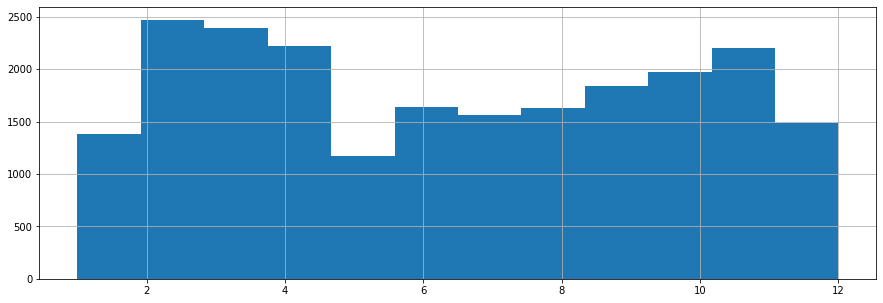

In [80]:
data['month'].hist(bins = 12, figsize = (15,5))

Чаще всего объявления выкладывают в марте. Реже всего - в июне.

<AxesSubplot:>

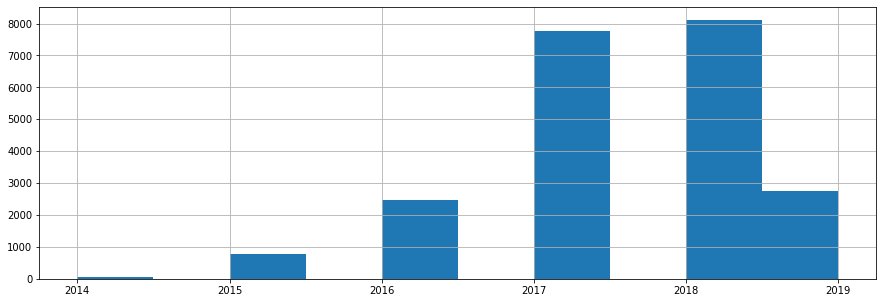

In [81]:
data['year'].hist(figsize = (15,5))

Меньше всего объявлений было выложено в 2014 - 2016 годах. С 2017 года количество размещаемых объявлений значительно выросло. В 2019 количество объявлений упало до уровня 2016 года. Полагаю, э тосвязано с тем, что выгрузка была сделала в середине 2019 года.

<div class="alert alert-success">
✔️ Комментарий ревьюера ✔️ 

Хороший результат. Хочу добавить, что обычно размеры двухкомнатных квартир составляют от 50 до 100 квадратных метров, что и соответствует проведенному анализу.
    
Могу посоветовать на будущее хорошую статью по оформлению графиков:
    https://devpractice.ru/matplotlib-lesson-3-3-text-elements/    
        
    
    
</div>

#### `days_exposition`

<AxesSubplot:>

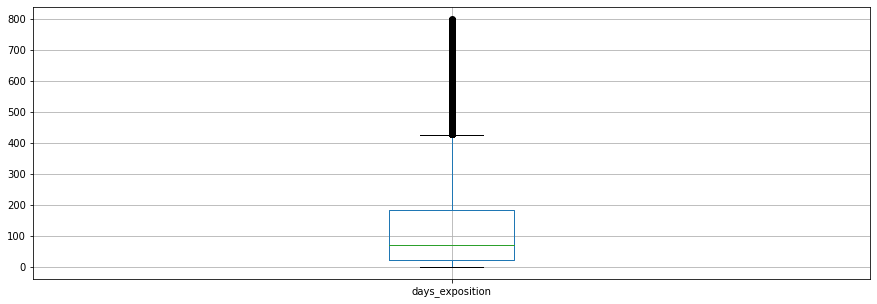

In [82]:
data.boxplot('days_exposition', figsize = (15,5))

<AxesSubplot:>

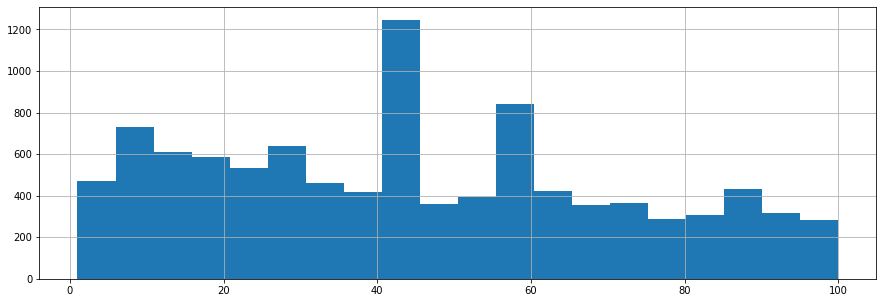

In [83]:
#data['days_exposition'].hist(figsize = (15,5))
data['days_exposition'].hist(range = (1, 100), bins = 20, figsize = (15,5))

In [84]:
data['days_exposition'].describe()

count    21964.000000
mean       134.401885
std        162.010617
min          0.000000
25%         21.000000
50%         70.000000
75%        183.000000
max        799.000000
Name: days_exposition, dtype: float64

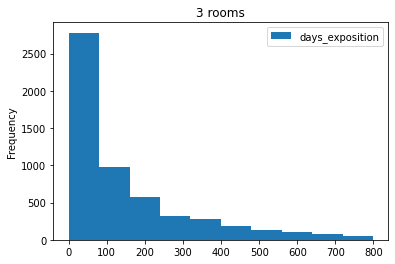

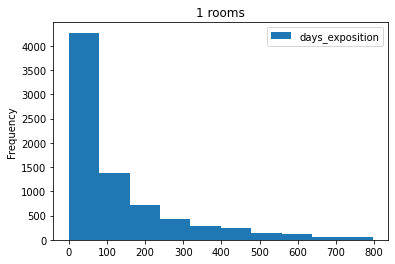

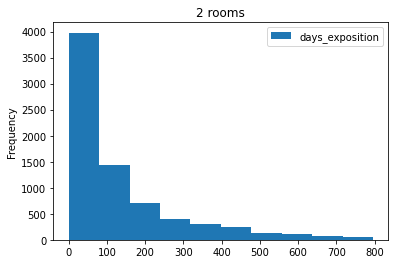

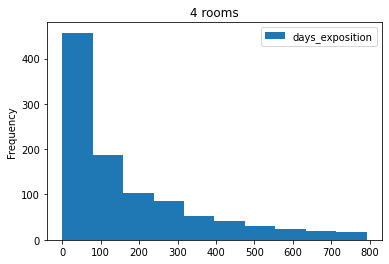

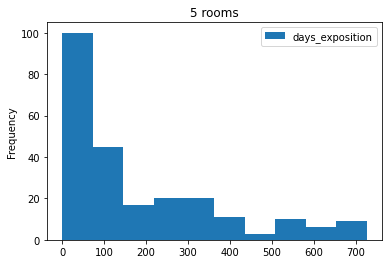

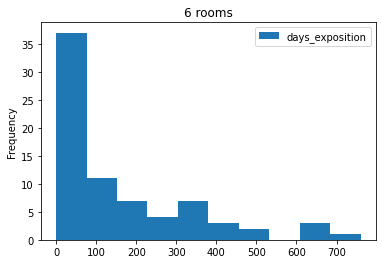

In [85]:
for rooms in data['rooms'].unique():
    title = str(rooms) + ' rooms'
    data.loc[data['rooms'] == rooms, ['days_exposition']].plot(y = 'days_exposition', kind = 'hist', bins = 10, title = title)

- В основном квартиры продаются за период до 183 дней. 
- Медианный срок продажи квартиры - 70 дней. 
- В среднем квартира продается за 134 дня.
- Быстрой можно назвать продажу квартиры до 40 дней. 
- В районе 45, 60 и 85 дней виден необычный рост чтсла проданных квартир.
- Квартиры с 1 - 3 комнатами продаются примерноза одно и то же время. Далее, по мере увеличения количества комнат, срок продажи растет. 
- Аномально большие сроки продажи квартир могут быть обусловлены как действительно долгой продажей квартиры, так и тем, что пользователь может забыть закрыть объявление в случае успешной продажи.

In [86]:
#Посмотрим что влияет на скоросро продажм квартиры
sbrn.heatmap(data.corr()[['days_exposition']])
#Вот тут не совсем понятно. Получается практически ничего не оказывает влияние на срок продажи квартиры. 
#Я ожидал, что будет зависимость хотя бы от цены. Либо я гле-то ошибся в процессе решения, либо в наборе остались +- рыночные предложения

NameError: name 'sbrn' is not defined

#### Влияние на цену различных факторов

In [116]:
#Создадим срез данных с интересующими нас столбцами
data_cut = data[['last_price', 
                 'total_area', 
                 'living_area', 
                 'kitchen_area', 
                 'rooms', 
                 'wich_floor', 
                 'week_day', 
                 'month', 
                 'year']]
data_cut.corr()[['last_price']]

,last_price
last_price,1.000000
total_area,0.669481
living_area,0.579938
kitchen_area,0.532082
rooms,0.374984
week_day,-0.007604
month,-0.007229
year,-0.027326


Общая площадь, жилая площадь и площадь кухни оказывают наиболее существенное влияние на стоимость квартиры. Самое больше значение оказывает общая площадь квартиры, что логично. Жилая площадь и площадь кухни влияют в меньшей степени, однако если вычистить данные более тщательно, то думаю, можно привести коэффициент корреляции этих переменных примерно к одному значению, поскольку все они связаны друг между другом.

Количество комнат влияет меньше, чем общая площадь. Это странно. Ожидалось, что коэффициент корреляции между количеством комнат и стоимостью квартиры будет выше, так как количество комнат сильно влияет на общую и жилую площадь квартиры. Возможно где - то не удалил аномальные значения и из-за этого сбился коэффициент корреляции.

День, месяц и год, когда объявление размещалось практически не влияет на стоимость квартиры.

<AxesSubplot:>

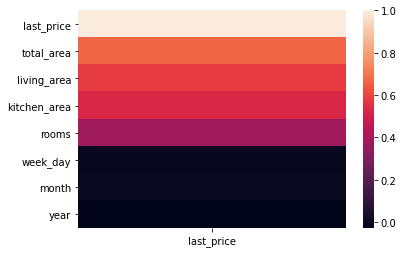

In [94]:
#Посмтроим Heatmap для красоты. plotting.scatter_matrix решил не строить, так как этот график не очень удобно читается.
sbrn.heatmap(data_cut.corr()[['last_price']])

In [119]:
#Посмотрим как менялась медианная цена квартир с каждым годом
median_year = (data
               .groupby('year')['last_price_thousands']
               .median()
               .reset_index())

Интерсно получается, в 2014 году медианная цена квартиры была выше, чем в последующие годы. Полагаю это связано с тем, что в 2014 годы были введены санкции, что сказалось на стоимости строительства жилья, а значит и на итоговой стоимости квартир. С 2015 года ситуация стабилизировалаь и стоимость недвижимости упала.

In [108]:
#Посмотрим как влияет на цену квартиры месяц размещения объявления
median_month = (data
                .groupby('month')['last_price_thousands']
                .median()
                .reset_index())

median_year = (data
               .groupby('year')['last_price_thousands']
               .median()
               .reset_index())

median_week_day = (data
                   .groupby('week_day')['last_price_thousands']
                   .median()
                   .reset_index())


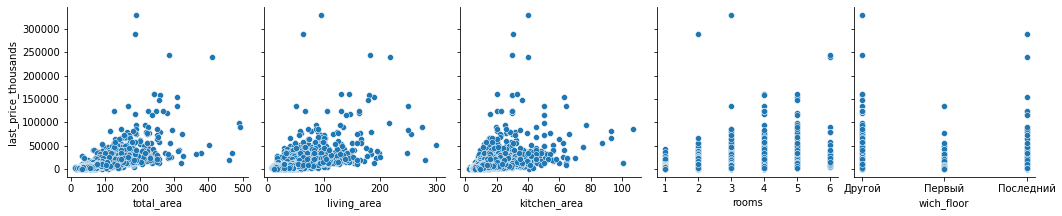

In [121]:
sbrn.pairplot(
    data,
    kind = 'scatter',
    x_vars=['total_area', 
            'living_area', 
            'kitchen_area', 
            'rooms', 
            'wich_floor'],
    y_vars=["last_price_thousands"],
    height=3)

На графике видно, что цена зависит от площади квартиры и количества комнат. Чем больше комнат в квартире, тем выше цена. Это логично. На графике стоимость пятикомнатных шестикомнатных квартир несколько выбивается из этой логики. Это связано с тем, что пятикомнатных и шестикомнатных квартир в набор данных значительно меньше чем всех прочих.

Квартиры на первых этажах стоят меньше всего. В остальном стоимость квартир не зависит от этажа, на котором она располагается.

In [122]:
data['rooms'].value_counts()

1    7704
2    7441
3    5484
4    1019
5     241
6      75
Name: rooms, dtype: int64

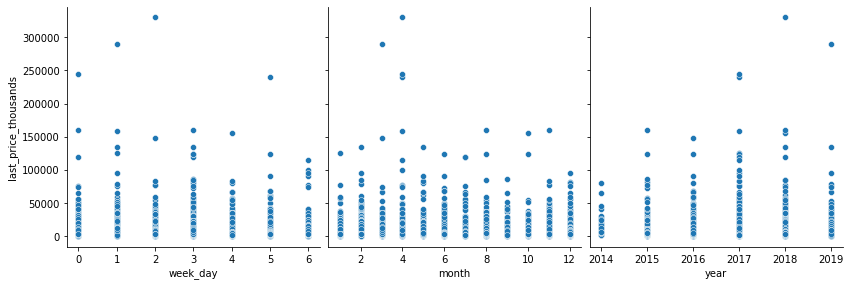

In [123]:
sbrn.pairplot(
    data,
    kind = 'scatter',
    x_vars=["week_day", "month", "year"],
    y_vars=["last_price_thousands"],
    height=4)

На графике видно, что цена практически не зависит от того, в какой день недели было ращмещено объявление. Весной и в декабре квартиры стоят несколько дороже. Осенью цена квартир самая низкая. Самые дорогие квартиры были размещены в 2017 году. Квартиры с самой низкой ценой - в 2014 году.

#### Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 

In [ ]:
#Топ 10 населенных пунктов по количеству объявлений:
(data
    .pivot_table(index = 'locality_name', values = 'price_per_sqm', aggfunc = ('count', 'mean'))
    .round(decimals = 2)
    .sort_values(by = 'count', ascending = False)
    .reset_index()
    .rename(columns = {'locality_name' : 'Населенный пункт', 
                                'count' : 'Количество объявлений', 
                                'mean' : 'Средняя цена за м2'})
    .head(10))


In [ ]:
#Топ 10 населенных пунктов с самой низкой стоимостью 1 м2:

(data
    .pivot_table(index = 'locality_name', values = 'price_per_sqm', aggfunc = ('count', 'mean'))
    .round(decimals = 2)
    .sort_values(by = 'mean', ascending = True)
    .reset_index()
    .rename(columns = {'locality_name' : 'Населенный пункт', 
                                'count' : 'Количество объявлений', 
                                'mean' : 'Средняя цена за м2'})
    .head(10))

#### Вычисление стоимость каждого киллометра удаления от центра и влияние удаленности от центра на стоимость квартиры

In [ ]:
#Cтоимость каждого киллометра удаления от центра
far_from_center = (data.loc[(data['locality_name'] == 'Санкт-Петербург') & 
                            (data['cityCenters_nearest_km'] >= 0), ['locality_name',
                                                 'last_price',
                                                 'price_per_sqm', 
                                                 'total_area', 
                                                 'rooms', 
                                                 'cityCenters_nearest_km']]
                   .sort_values('cityCenters_nearest_km')
                   .pivot_table(index = 'cityCenters_nearest_km', values = 'price_per_sqm', aggfunc = 'median')
                   .round(decimals = 2)
                   .reset_index()
                   .rename(columns = {'cityCenters_nearest_km' : 'Расстояние до центра, км', 
                                   'price_per_sqm' : 'Медианная цена за м2'}))
far_from_center

In [ ]:
#Средняя стоимость каждого км удаления от центра:
mean_center_km = far_from_center['Медианная цена за м2'].mean()
print(f'При удалении от центра СПб, стоимость одного квадратного метра в среднем снижается на - {mean_center_km.round(decimals = 2)} рубелй каждый километр.')

In [ ]:
#Влияние удаленности от центра на цену квартиры
(data.loc[(data['locality_name'] == 'Санкт-Петербург') & 
         (data['cityCenters_nearest_km'] >= 0), ['locality_name',
                                                 'last_price',
                                                 'price_per_sqm', 
                                                 'total_area', 
                                                 'rooms', 
                                                 'cityCenters_nearest_km']]
    .sort_values('cityCenters_nearest_km')
    .pivot_table(index = 'cityCenters_nearest_km', values = 'price_per_sqm', aggfunc = 'median')
    .round(decimals = 2)
    .reset_index()
    .plot(x = 'cityCenters_nearest_km', y = 'price_per_sqm', kind = 'bar', figsize = (15,5)))

На графике видно, что стоимость одного м2 постепенно снижается по мере удаления от центра. Однако на промежутках 4 - 6 км от центра наблюдается рост стоимость одного м2. Скорее - всего это связано с тем, что определяется расстояние не от исторического, а от географического центра города. 

Согласно гуглу - географический центр города - в районе Гостинного двора. На расстоянии 4-6 км как раз располагается Петроградский район, где стоимость одного м2 жилья достаточно высока. 

На участке 6 - 8 цена падает. Как раз за петроградским районом следует район черной речки, где много типового советского жилья.

Пик на расстоянии 27 км скорее - всего связан с тем, что в этот радиус попадает пригород свысокой стоимостью недвижимости: Сестрорецк, Пушкин, Павловск, Петергоф.

### Общий вывод

Из набора данных, можно сделать вывод, что в основном на продажу выставляются двухкомнатные квартиры площадью 50 м2. Больше всего объявлений в Санкт - Петербурге и его пригородах. Остальные объявления из Ленинградской области. Средняя высота потолка в продаваемой квартире 2,5 м. Квартиры с 1 - 3 комнатами продаются в основнмо до 100 дней. Далее, по мере увеличесния количества комнат, срок продажи растет. Цена квартиры практически не зависит от того, в какой день недели размещается объявление. Весной и в декабре квартиры стоят несколько дороже. Осенью цена квартир самая низкая. Самые дорогие квартиры были размещены в 2017 году. Квартиры с самой низкой ценой - в 2014 году.

Квартиры на первых этажах стоят меньше всего. В остальном стоимость квартир не зависит от этажа, на котором она располагается.

На стоимость жилья в большей степени влияет его площадь. 
Самые дорогие квартиры в  центре Санкт - Петребрга, на расстоянии до 8 км от центра, и в ближайших пригородах. Самые дорогие квартиры ЛО в Гатчине и Выборге. Квартиры с самой низкой ценой в деревнях ЛО, вдали от крупных городов.